# Breast Histopathology Cancer Detection

In [1]:
import os 
import cv2
import numpy as np
from tqdm import tqdm
import shutil
REBUILD_DATA = True

## Making a cleaner directory for the images. Right now the images are in convoluted folders

In [311]:
not_cancer_director = '/Users/paras/Downloads/all_cancer'
os.mkdir(cancer_director)

In [291]:
p_list = os.listdir("/Users/paras/Downloads/breast-histopathology-images")

In [312]:
for p in p_list:
    try:
        p_0 = '/Users/paras/Downloads/breast-histopathology-images/' + str(p) + '/0'
        p_1 = '/Users/paras/Downloads/breast-histopathology-images/' + str(p) + '/1'
        f_list_0 = os.listdir(p_0)
        f_list_1 = os.listdir(p_1)
        for f_name in f_list_0:
            source = os.path.join(p_0, f_name)
            destination = os.path.join("/Users/paras/Downloads/all_cancer/0", f_name)
            shutil.copyfile(source, destination)
        for f_name in f_list_1:
            source = os.path.join(p_1, f_name)
            destination = os.path.join("/Users/paras/Downloads/all_cancer/1", f_name)
            shutil.copyfile(source, destination)     
    except Exception as e:
        print(e)
        continue

[Errno 20] Not a directory: '/Users/paras/Downloads/breast-histopathology-images/.DS_Store/0'


In [8]:
no_cancer=os.listdir("/Users/paras/Downloads/all_cancer/0")

## Making a directory with labels for cancer

In [2]:
class cancer():
    img_size=50
    no_cancer="/Users/paras/Downloads/all_cancer/0"
    cancer="/Users/paras/Downloads/all_cancer/1"
    labels={no_cancer:0, cancer:1}
    training_data=[]
    no_cancer_count=0
    cancer_count=0
    i=0
    def make_training_data(self):
        for label in self.labels:
            try:
                print(label)
                try:
                    for f in tqdm(os.listdir(label)):
                        self.i+=1
                        path=os.path.join(label,f)
                        img=cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        if img is None:
                            continue
                        if self.i==79000:
                            break
                        img = cv2.resize(img, (self.img_size, self.img_size))
                        self.training_data.append([np.array(img), np.eye(2)[self.labels[label]]])
                        if label == self.no_cancer:
                            self.no_cancer_count+=1
                        elif label == self.cancer:
                             self.cancer_count+=1
                except Exception as e:
                    print(e)
                    continue
            except Exception as e:
                print(e)
                pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        print(self.no_cancer_count,self.cancer_count)
if REBUILD_DATA:
    c=cancer()
    c.make_training_data()

/Users/paras/Downloads/all_cancer/0


  0%|          | 0/78786 [00:00<?, ?it/s]

/Users/paras/Downloads/all_cancer/1



 84%|████████▍ | 66279/78786 [00:14<00:02, 4671.88it/s]


100%|██████████| 78786/78786 [00:16<00:00, 4638.53it/s]

78998 78786


In [3]:
training_data=np.load("training_data.npy",allow_pickle=True)

In [4]:
import matplotlib.pyplot as plt

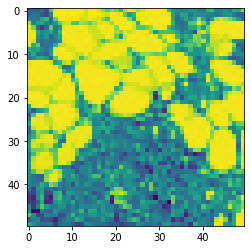

In [5]:
plt.imshow(training_data[200][0])

In [14]:
training_data[200][1]

array([0., 1.])

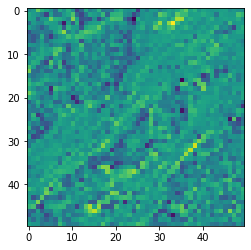

In [15]:
plt.imshow(training_data[100][0])

In [16]:
training_data[100][1]

array([0., 1.])

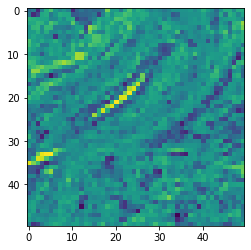

In [17]:
plt.imshow(training_data[0][0])

In [18]:
training_data[0][1]

array([0., 1.])

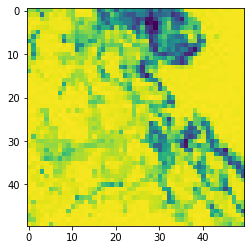

In [19]:
plt.imshow(training_data[700][0])

In [21]:
training_data[700][1]

array([1., 0.])

## Neural Network

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,32,5)
        self.conv2=nn.Conv2d(32,64,5)
        self.conv3=nn.Conv2d(64,128,5)
        x=torch.randn(50,50).view(-1,1,50,50)
        x=self.convs(x)
        self.f=torch.flatten(x).shape[0]   
        self.fc1=nn.Linear(self.f,512)
        self.fc2=nn.Linear(512, 2)
    
    def convs(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x=F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x=F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        return x
    
    def forward(self, x):
        x=self.convs(x)
        x=x.view(-1,self.f)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return F.softmax(x, dim=1)

In [7]:
net = Net()

In [8]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function= nn.MSELoss()

In [9]:
X=torch.Tensor([i[0] for i in training_data])
X=X/255.0
y=torch.Tensor([i[1] for i in training_data])

val_pct=0.1
val_size=int(len(X)*val_pct)

## Dividing the data into training and testing data

In [10]:
train_x=X[:-val_size]
train_y=y[:-val_size]


test_x=X[-val_size:]
test_y=y[-val_size:]

In [22]:
batch_size=100
epochs=3

for epoch in range(epochs):
    for i in tqdm(range(0,len(train_x),batch_size)):
        batch_X=train_x[i:i+batch_size].view(-1,1,50,50)
        batch_y=train_y[i:i+batch_size]
        net.zero_grad()
        outputs=net(batch_X)
        loss=loss_function(outputs,batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)


 11%|█         | 152/1421 [01:05<08:43,  2.42it/s]


 21%|██▏       | 303/1421 [02:09<08:03,  2.31it/s]


 32%|███▏      | 454/1421 [03:13<06:41,  2.41it/s]


 43%|████▎     | 605/1421 [04:16<06:20,  2.14it/s]


 53%|█████▎    | 756/1421 [05:21<05:07,  2.16it/s]


 64%|██████▍   | 907/1421 [06:25<03:35,  2.38it/s]


 74%|███████▍  | 1057/1421 [07:28<02:34,  2.35it/s]


 85%|████████▍ | 1205/1421 [08:29<01:30,  2.39it/s]


 95%|█████████▌| 1353/1421 [09:32<00:28,  2.38it/s]


  6%|▌         | 83/1421 [00:35<09:23,  2.37it/s]


 17%|█▋        | 235/1421 [01:38<08:14,  2.40it/s]


 27%|██▋       | 386/1421 [02:45<08:34,  2.01it/s]


 38%|███▊      | 537/1421 [03:52<06:15,  2.35it/s]


 48%|████▊     | 688/1421 [04:55<05:11,  2.36it/s]


 59%|█████▉    | 839/1421 [06:00<04:05,  2.37it/s]


 70%|██████▉   | 990/1421 [07:06<03:07,  2.29it/s]


 80%|████████  | 1139/1421 [08:11<02:02,  2.31it/s]


 91%|█████████ | 1287/1421 [09:14<00:56,  2.38it/s]


  1%|          | 14/1421 [00:06<10:56,  2.14it/s]


 12%|█▏        | 167/1421 [01:14<10:45,  1.94it/s]


 22%|██▏       | 318/1421 [02:18<07:47,  2.36it/s]


 33%|███▎      | 469/1421 [03:22<06:34,  2.42it/s]


 44%|████▎     | 620/1421 [04:27<05:41,  2.34it/s]


 54%|█████▍    | 771/1421 [05:36<05:44,  1.89it/s]


 65%|██████▍   | 922/1421 [06:43<04:11,  1.98it/s]


 75%|███████▌  | 1072/1421 [07:46<02:25,  2.41it/s]


 86%|████████▌ | 1220/1421 [08:48<01:26,  2.32it/s]


 96%|█████████▋| 1368/1421 [09:53<00:23,  2.30it/s]


100%|██████████| 1421/1421 [10:16<00:00,  2.31it/s]

tensor(0.1545, grad_fn=<MseLossBackward>)


In [25]:
total=0
correct=0
with torch.no_grad():
    for i in tqdm(range(len(test_x))):
        real_class=torch.argmax(test_y[i])
        net_out=net(test_x[i].view(-1,1,50,50))[0]
        predicted_class=torch.argmax(net_out)
        if predicted_class==real_class:
            correct+=1
        total+=1
print("Accuracy "+str(correct/total))


 44%|████▍     | 6930/15778 [00:14<00:17, 517.85it/s]


 92%|█████████▏| 14573/15778 [00:29<00:02, 546.73it/s]


100%|██████████| 15778/15778 [00:31<00:00, 493.57it/s]

Accuracy 0.7637850171124351
